## 1. Setup and Imports

In [3]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path

project_root = Path(__file__).parent.parent if '__file__' in dir() else Path('.').resolve().parent
sys.path.insert(0, str(project_root))
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')
print('✓ Imports successful')

✓ Imports successful


## 2. Data Loading

In [4]:
DATA_DIR = project_root / 'data' / 'parquet'
OUTPUT_DIR = project_root / 'data' / 'derived'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

papers = pd.read_parquet(DATA_DIR / 'papers')
citations_df = pd.read_parquet(DATA_DIR / 'citations')
coauthorships_df = pd.read_parquet(DATA_DIR / 'coauthorships')

print(f'Papers: {papers.shape[0]:,}')
print(f'Citations: {citations_df.shape[0]:,}')
print(f'Coauthorships: {coauthorships_df.shape[0]:,}')

Papers: 2,279,007
Citations: 12,313,182
Coauthorships: 8,254,017


## 3. Citation Outliers

In [5]:
in_degree = citations_df.groupby('dst_id').size().reset_index(name='in_degree')
citation_stats = papers[['id', 'title', 'year', 'venue', 'n_citation']].copy()
citation_stats = citation_stats.merge(in_degree, left_on='id', right_on='dst_id', how='left').fillna(0)
citation_stats['in_degree'] = citation_stats['in_degree'].astype(int)

scaler = StandardScaler()
citation_stats['z_citation'] = np.abs(scaler.fit_transform(citation_stats[['n_citation']]))
citation_stats['z_indegree'] = np.abs(scaler.fit_transform(citation_stats[['in_degree']]))

citation_outliers = citation_stats[(citation_stats['z_citation'] > 3) | (citation_stats['z_indegree'] > 3)].copy()
print(f'Citation Outliers: {len(citation_outliers):,}')

Citation Outliers: 16,608


## 4. Venue Anomalies

In [6]:
papers_clean = papers.dropna(subset=['title', 'venue']).copy()
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(papers_clean['title'])

venue_anomalies = []
for venue in papers_clean['venue'].value_counts().head(20).index:
    venue_papers = papers_clean[papers_clean['venue'] == venue]
    if len(venue_papers) >= 10:
        venue_tfidf = tfidf_matrix[venue_papers.index]
        iso_forest = IsolationForest(contamination=0.05, random_state=42)
        scores = iso_forest.fit_predict(venue_tfidf.toarray())
        venue_anomalies.extend([{'venue': venue} for idx, s in zip(venue_papers.index, scores) if s == -1])

venue_anomalies_df = pd.DataFrame(venue_anomalies)
print(f'Venue Anomalies: {len(venue_anomalies_df):,}')

Venue Anomalies: 27,642


## 5. Visualization

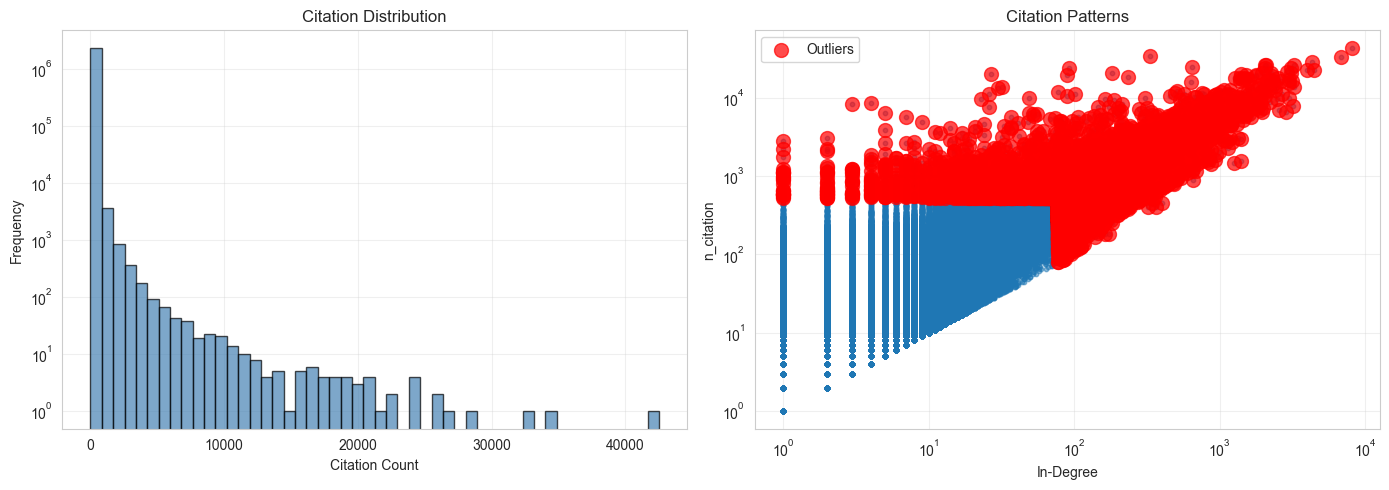

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(citation_stats['n_citation'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Citation Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Citation Distribution')
axes[0].set_yscale('log')
axes[0].grid(alpha=0.3)

axes[1].scatter(citation_stats['in_degree'], citation_stats['n_citation'], alpha=0.5, s=10)
if len(citation_outliers) > 0:
    axes[1].scatter(citation_outliers['in_degree'], citation_outliers['n_citation'], 
                    color='red', s=100, alpha=0.7, label='Outliers')
axes[1].set_xlabel('In-Degree')
axes[1].set_ylabel('n_citation')
axes[1].set_title('Citation Patterns')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'anomaly_analysis_plot.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Export Results

In [8]:
summary = pd.DataFrame({
    'Type': ['Citation Outliers', 'Venue Anomalies'],
    'Count': [len(citation_outliers), len(venue_anomalies_df)]
})

print('\n' + '='*50)
print('ANOMALY DETECTION SUMMARY')
print('='*50)
print(summary.to_string())
print('='*50)

citation_outliers[['id', 'title', 'year', 'venue', 'n_citation', 'in_degree']].to_csv(
    OUTPUT_DIR / 'anomalies_citation_outliers.csv', index=False)
venue_anomalies_df.to_csv(OUTPUT_DIR / 'anomalies_venue_offTopic.csv', index=False)
summary.to_csv(OUTPUT_DIR / 'anomaly_detection_summary.csv', index=False)

print('\n✓ Results exported to data/derived/')


ANOMALY DETECTION SUMMARY
                Type  Count
0  Citation Outliers  16608
1    Venue Anomalies  27642

✓ Results exported to data/derived/
